In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import curve_fit

In [2]:
matplotlib.rcParams.update({'font.size': 22})

In [3]:
f = uproot.open('output_000496.root')

In [4]:
data = f['midas_data']

In [5]:
tdc = data['tdc_value'].array(library="np", entry_start=0)

In [6]:
adc = data['adc_value'].array(library="np", entry_start=0)

In [7]:
adc[1]

array([443, 940, 869, 327, 362, 317, 290, 300, 134, 186, 140, 156, 147,
       141, 153, 185, 123, 144, 150, 196, 149, 153, 160, 190, 153, 184,
       161, 143, 144, 164, 144, 149], dtype=int32)

In [8]:
adc_data = {'BC1':[], 'BC2':[], 'BC3':[], 
       'C2':[], 'C3':[], 'C4':[], 'C5':[], 'C6':[]}
for adc_i in adc:
#     print(adc_i)
    adc_data['BC1'].append(adc_i[0])
    adc_data['BC2'].append(adc_i[1])
    adc_data['BC3'].append(adc_i[2])
    
    adc_data['C2'].append(adc_i[3])
    adc_data['C3'].append(adc_i[4])
    adc_data['C4'].append(adc_i[5])
    adc_data['C5'].append(adc_i[6])
    adc_data['C6'].append(adc_i[7])

In [9]:
tdc_data = {'BC1':[], 'BC2':[], 'BC3':[], 
       'C2':[], 'C3':[], 'C4':[], 'C5':[], 'C6':[]}
for tdc_i in tdc:
#     print(tdc_i)
    tdc_data['BC1'].append(tdc_i[1])
    tdc_data['BC2'].append(tdc_i[2])
    tdc_data['BC3'].append(tdc_i[3])

In [10]:
for k in tdc_data.keys():
    tdc_data[k] = np.array(tdc_data[k])

In [11]:
for k in adc_data.keys():
    adc_data[k] = np.array(adc_data[k])

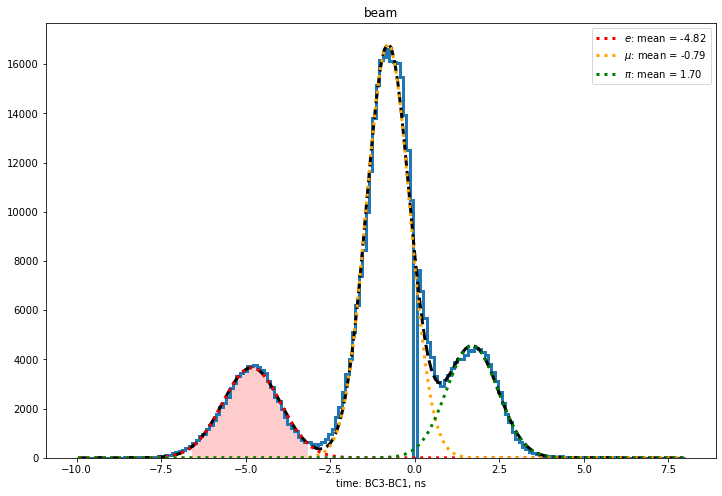

In [12]:
def gauss(x, *p):
    A, t0, v = p
    return A*np.exp(-(x-t0)**2/(2.*v))

plt.figure(figsize=(12,8))
plt.title('beam')

dt = tdc_data['BC3']-tdc_data['BC1']
mask = dt != 0

h, b, _ = plt.hist(dt[mask]/10., 
                     179, range=(-10, 8),
                     histtype='step', lw=3)

def comb_gauss(x, *p):
    distr = 0
    for j in range(3):
        distr += gauss(x, *[p[j*3],p[j*3+1],p[j*3+2]])
    return distr

bin_centres = b[:-1] + (b[1]-b[0])/2
coeff, _ = curve_fit(comb_gauss, bin_centres, h, p0=[4000, -5, 1, 16000, -1, 1, 4000, 2, 1])
mask_e = mask*(dt/10>coeff[1]-2*np.sqrt(coeff[2]))*(dt/10<coeff[1]+2*np.sqrt(coeff[2]))
fit_hist = comb_gauss(bin_centres, *coeff)
plt.plot(bin_centres, fit_hist, c='k', lw=3, ls='--')

plt.plot(bin_centres, gauss(bin_centres, *coeff[0:3]), c='r', lw=3, ls=':', 
        label=f'$e$: mean = {coeff[1]:.2f}')
plt.plot(bin_centres, gauss(bin_centres, *coeff[3:6]), c='orange', lw=3, ls=':', 
        label=f'$\mu$: mean = {coeff[4]:.2f}')
plt.plot(bin_centres, gauss(bin_centres, *coeff[6:]), c='g', lw=3, ls=':', 
        label=f'$\pi$: mean = {coeff[7]:.2f}')

plt.hist(dt[mask_e]/10, 
         179, range=(-10, 8),
         histtype='stepfilled', lw=3, alpha=0.2, color='r')

plt.xlabel('time: BC3-BC1, ns')
plt.legend()

In [14]:
dt_e = dt[mask_e]/10 #ns

In [15]:
length = 3.18 #m

In [16]:
speed_e = length/dt_e

(array([ 647.,  730.,    0.,  850.,    0., 1070., 1212., 1389.,    0.,
        1667., 1972., 2303., 2462.,    0., 2864., 3133., 3459., 7266.,
        3784., 3751., 3727., 3522., 6796., 3059., 5314., 4287., 1773.,
        2851., 2125., 2210.]),
 array([-0.99375   , -0.97693269, -0.96011538, -0.94329808, -0.92648077,
        -0.90966346, -0.89284615, -0.87602885, -0.85921154, -0.84239423,
        -0.82557692, -0.80875962, -0.79194231, -0.775125  , -0.75830769,
        -0.74149038, -0.72467308, -0.70785577, -0.69103846, -0.67422115,
        -0.65740385, -0.64058654, -0.62376923, -0.60695192, -0.59013462,
        -0.57331731, -0.5565    , -0.53968269, -0.52286538, -0.50604808,
        -0.48923077]),
 <BarContainer object of 30 artists>)

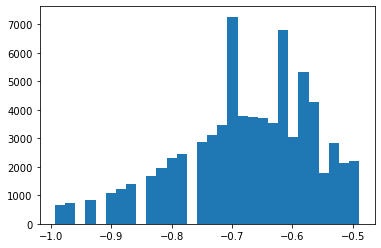

In [17]:
plt.hist(speed_e, 30)

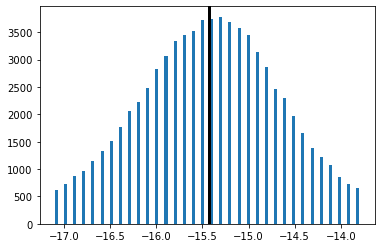

In [18]:
offset = dt_e - length/0.3
plt.hist(offset, 100)
offset_mean = np.mean(offset)
plt.axvline(offset_mean, c='k', lw=3)

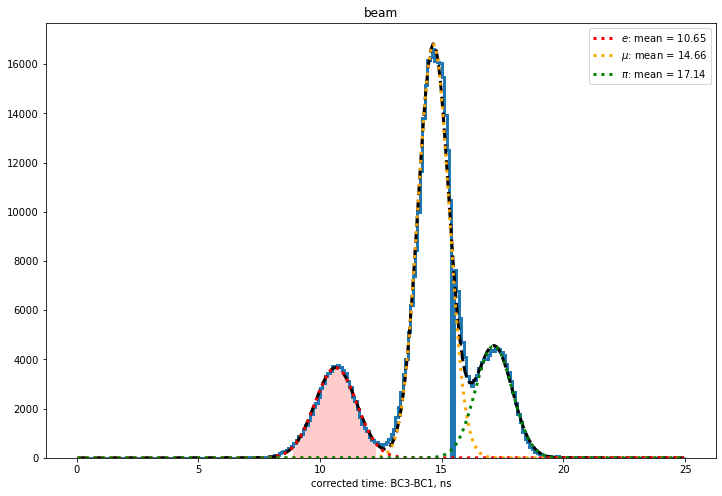

In [19]:
plt.figure(figsize=(12,8))
plt.title('beam')

h, b, _ = plt.hist(dt[mask]/10.-offset_mean, 
                     250, range=(0, 25),
                     histtype='step', lw=3)

def comb_gauss(x, *p):
    distr = 0
    for j in range(3):
        distr += gauss(x, *[p[j*3],p[j*3+1],p[j*3+2]])
    return distr

bin_centres = b[:-1] + (b[1]-b[0])/2
coeff_corr, _ = curve_fit(comb_gauss, bin_centres, h, p0=[4000, 10, 1, 16000, 14, 1, 4000, 17, 1])
fit_hist = comb_gauss(bin_centres, *coeff_corr)
plt.plot(bin_centres, fit_hist, c='k', lw=3, ls='--')

plt.plot(bin_centres, gauss(bin_centres, *coeff_corr[0:3]), c='r', lw=3, ls=':', 
        label=f'$e$: mean = {coeff_corr[1]:.2f}')
plt.plot(bin_centres, gauss(bin_centres, *coeff_corr[3:6]), c='orange', lw=3, ls=':', 
        label=f'$\mu$: mean = {coeff_corr[4]:.2f}')
plt.plot(bin_centres, gauss(bin_centres, *coeff_corr[6:]), c='g', lw=3, ls=':', 
        label=f'$\pi$: mean = {coeff_corr[7]:.2f}')

plt.hist(dt[mask_e]/10-offset_mean, 
         250, range=(0, 25),
         histtype='stepfilled', lw=3, alpha=0.2, color='r')

plt.xlabel('corrected time: BC3-BC1, ns')
plt.legend()

In [20]:

theta = np.array([90, 30,  330, 270, 210]) # 180-30, 180+30, 270, 330]) 
x = np.cos(theta/180*np.pi)
y = np.sin(theta/180*np.pi)




In [21]:
x

array([ 6.12323400e-17,  8.66025404e-01,  8.66025404e-01, -1.83697020e-16,
       -8.66025404e-01])

(-1.5, 1.5)

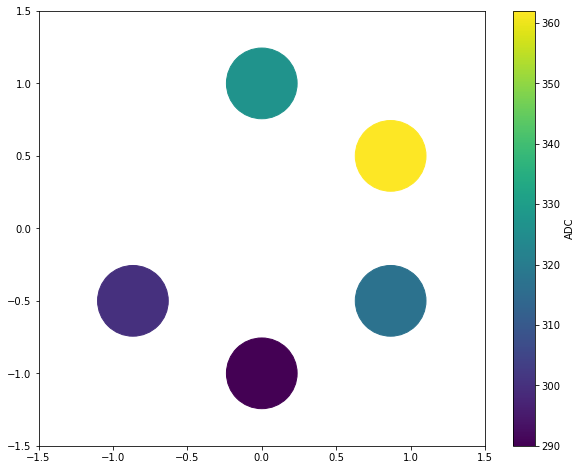

In [22]:
plt.figure(figsize=(10,8))

plt.scatter(x, y, s=5000, 
            c=[adc_data['C2'][1], adc_data['C3'][1], adc_data['C4'][1], 
               adc_data['C5'][1], adc_data['C6'][1]])

plt.colorbar(label='ADC')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

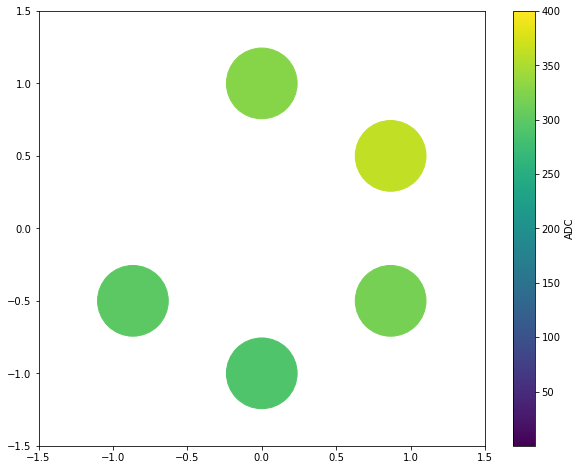

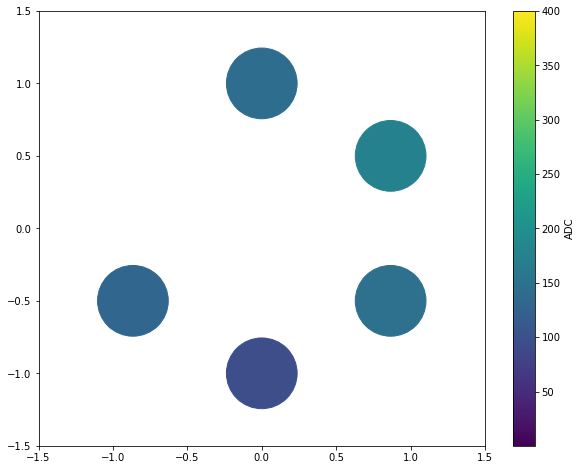

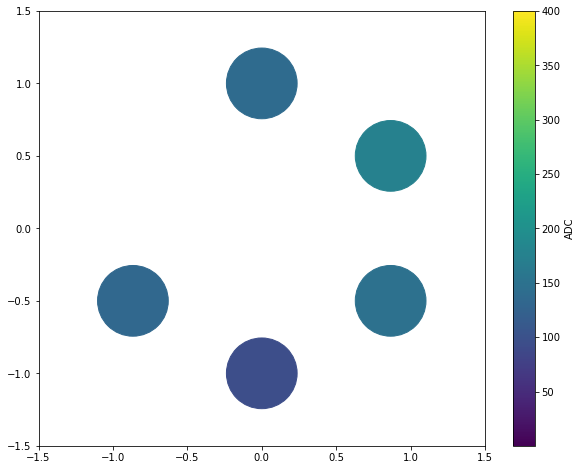

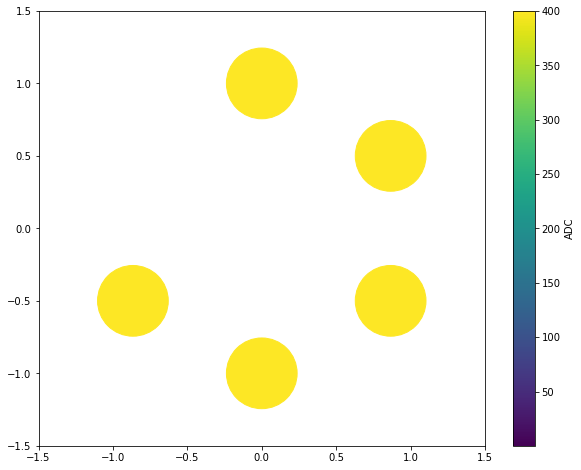

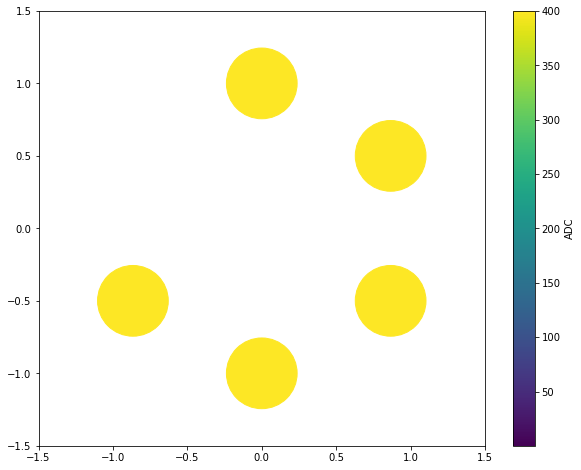

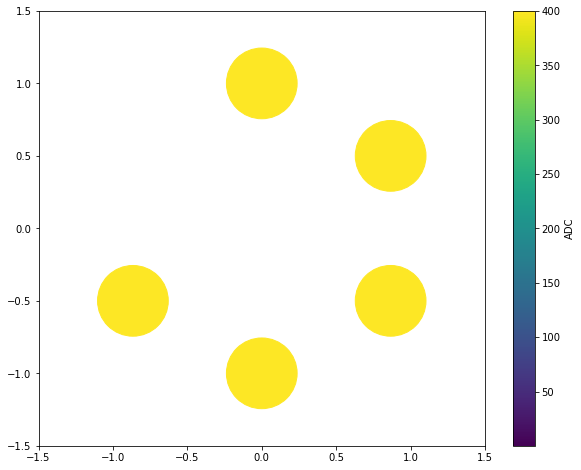

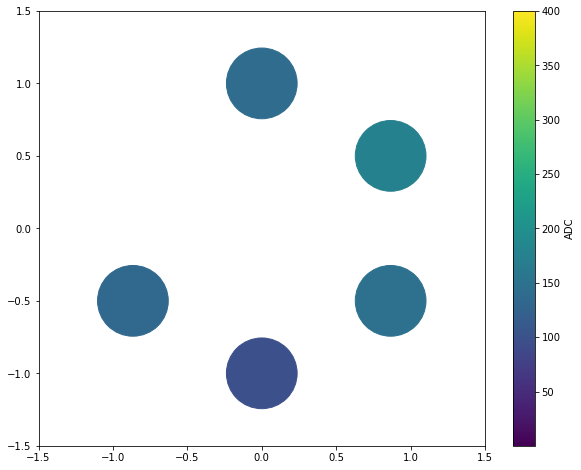

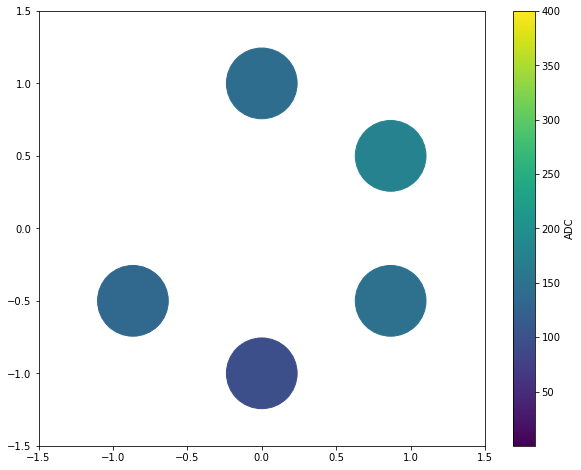

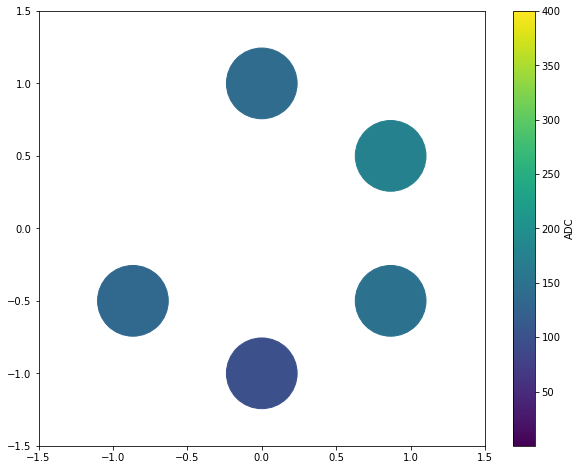

In [23]:
for i in range(1,10):
    plt.figure(figsize=(10,8))
    plt.scatter(x, y, s=5000, 
                c=[adc_data['C2'][i], adc_data['C3'][i], adc_data['C4'][i], 
                   adc_data['C5'][i], adc_data['C6'][i]],
                norm=matplotlib.colors.Normalize(vmin=0.1, vmax=400))

    plt.colorbar(label='ADC')
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)

In [24]:
l = len(adc_data['C2'])

(-1.5, 1.5)

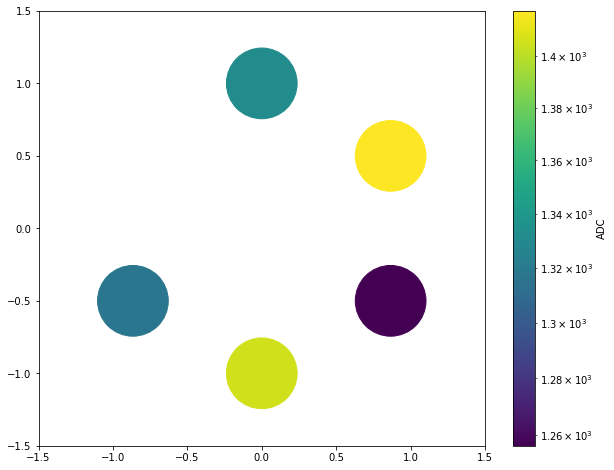

In [25]:
plt.figure(figsize=(10,8))

plt.scatter(x, y, s=5000, 
            c=[sum(adc_data['C2'])/l, sum(adc_data['C3'])/l, sum(adc_data['C4'])/l, 
               sum(adc_data['C5'])/l, sum(adc_data['C6'])/l],
            norm=matplotlib.colors.LogNorm())

plt.colorbar(label='ADC')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

(-1.5, 1.5)

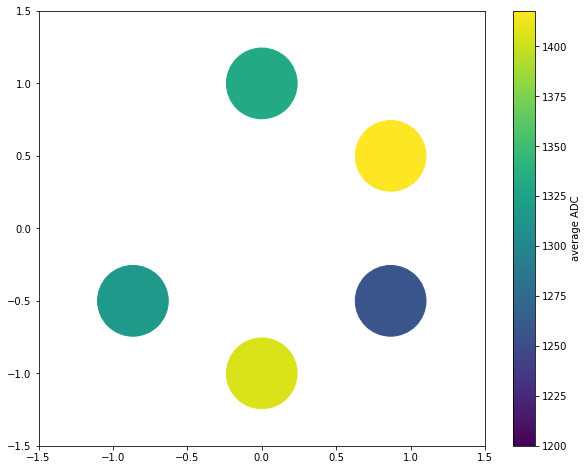

In [26]:
plt.figure(figsize=(10,8))

plt.scatter(x, y, s=5000, 
            c=[sum(adc_data['C2'])/l, sum(adc_data['C3'])/l, sum(adc_data['C4'])/l, 
               sum(adc_data['C5'])/l, sum(adc_data['C6'])/l],
            norm=matplotlib.colors.Normalize(vmin=1200))

plt.colorbar(label='average ADC')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

(-1.5, 1.5)

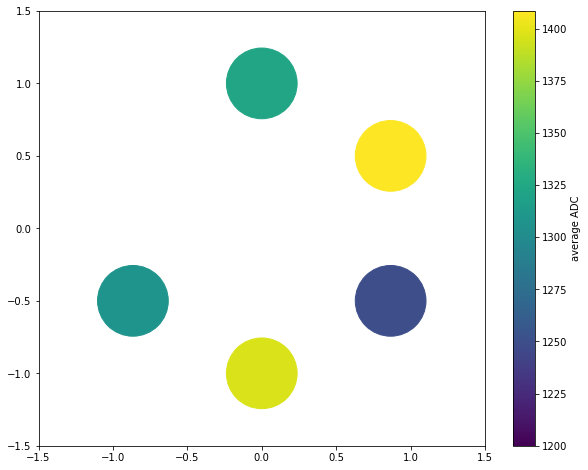

In [27]:
plt.figure(figsize=(10,8))

plt.scatter(x, y, s=5000, 
            c=[sum(adc_data['C2'][:int(l/2)])/l*2, sum(adc_data['C3'][:int(l/2)])/l*2, sum(adc_data['C4'][:int(l/2)])/l*2, 
               sum(adc_data['C5'][:int(l/2)])/l*2, sum(adc_data['C6'][:int(l/2)])/l*2],
            norm=matplotlib.colors.Normalize(vmin=1200))

plt.colorbar(label='average ADC')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

(-1.5, 1.5)

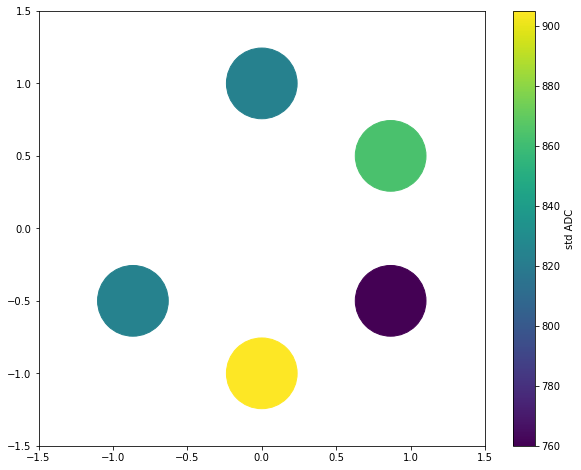

In [28]:
plt.figure(figsize=(10,8))

plt.scatter(x, y, s=5000, 
            c=[np.std(adc_data['C2']), np.std(adc_data['C3']), np.std(adc_data['C4']), 
               np.std(adc_data['C5']), np.std(adc_data['C6'])],
            norm=matplotlib.colors.Normalize())

plt.colorbar(label='std ADC')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)